In [ ]:
# Copyright 2025 Andrew Lehr
# The MIT License

## Fig 4

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os.path as path
import os
from tabulate import tabulate
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [2]:
from submanifolds.utils import get_root
from submanifolds.ringnet import RingNetworkDynamicSelection as RingNetwork
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import DataManager

In [3]:
colors = ['#173F5f', '#f26c4f','#5791b3']

In [4]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [5]:
N = 1000
T = 1000
sigma = 0.08
shift = 0.06
weight = 10 #9.5 #6 #9.5

tau = 10 #20
tau_I = 10 #20

seed = 0
np.random.seed(seed)

params_to_update = {'keys':     ['sigma_percent', 'shift_percent', 'T', '_w_E'], 
                    'setting':  [sigma, shift, T, weight]}

p = 0.8 
w_ei = 10
inds_1 = np.random.choice(N, int(p*N), replace=False)
w_ei_1 = np.zeros(N)
w_ei_1[inds_1] = w_ei

inds_2 = np.random.choice(N, int(p*N), replace=False)
w_ei_2 = np.zeros(N)
w_ei_2[inds_2] = w_ei

w_ie = .02
w_ii = 25
I_ext_1 = np.zeros(T)
I_ext_2 = np.zeros(T)

w_ext = 25
t_ext_1 = 0
sd = 25 #15
t_ext_2 = int(T/2)
t = np.arange(0,T)
I_ext_1 = gaussian(t,w_ext,t_ext_1,sd)
I_ext_2 = gaussian(t,w_ext,t_ext_2,sd)

### Run simulation

In [6]:
params = Parameters(params_to_update)
net = RingNetwork(params, tau=tau, tau_I=tau_I, w_ei_1=w_ei_1, w_ei_2=w_ei_2, w_ie=w_ie, w_ii=w_ii, I_ext_1=I_ext_1, I_ext_2=I_ext_2) 
net.run()

### Table of parameter values

In [7]:
print(tabulate([['$N$',      str(N),                              'number of neurons'],
                ['$T$',      str(T),                              'number of time steps'],
                ['$\\tau$',   str(net.tau),     'synaptic time constant'],
                ['$w_E$',    str(np.round(net.params.w_E,4)),     'maximum excitatory weight between ring network neurons'],
                ['$\sigma$', str(int(net.params.sigma)),          'standard deviation of excitatory Gaussian kernel'],
                ['$s$',      str(int(net.params.shift)),               'shift magnitude of excitatory Gaussian kernel'],
                ['$w_I$',    str(np.round(net.params.w_I,4)),     'global inhibitory weight'],
                ['$w_{IE}$',    str(net.w_ie),     'weight from ring network neurons to selective inhibition ensembles'],
                ['$p_{inh}$',    str(p),     'fraction of ring network neurons silenced by each selective inhibition ensemble'],
                ['$w_{EI}$',    str(w_ei),     'weight from selective inhibition ensemble to targeted ring network neurons'],
                ['$w_{II}$',    str(net.w_ii),     'weight between selective inhibition ensembles'],
                ['$w_{ext}$',    str(w_ext),     'weight of top down input signal'],
                ['$\sigma_{ext}$',    str(sd),       'standard deviation of Gaussian activity for top down input signal'],
                ['$t_{ext, 1}$',    str(t_ext_1),       'peak time of top down input signal from ensemble 1'],
                ['$t_{ext, 2}$',    str(t_ext_2),       'peak time of top down input signal from ensemble 2'],
                ['$x_c$',    str(int(net.params.initial_bump_center)),     'initial bump center'],
                ['$\sigma_0$',    str(int(net.params.initial_bump_std)),     'initial bump width (standard deviation)'],
                ['$r_{max}(t=0)$',    str(int(net.params.initial_r.max())),     'initial bump amplitude, i.e. firing rate'],
                ['$I^E_i(t=0)$',      '$r^E_i(t=0)$',                      'initial synaptic current of ring neuron $i$ is set equal to its initial firing rate'],
                ['$r^I_{1}(t=0)$',    str(0),     'initial firing rate of selective inhibition ensemble 1'],
                ['$r^I_{2}(t=0)$',    str(0),     'initial firing rate of selective inhibition ensemble 2'],
                ['$I_{1}(t=0)$',    str(0),     'initial synaptic current of selective inhibition ensemble 1'],
                ['$I_{2}(t=0)$',    str(0),     'initial synaptic current of selective inhibition ensemble 2']
               ], 
               headers=['parameter', 'value', 'description'],
               numalign='center', stralign='center', tablefmt='latex_raw'))

\begin{tabular}{ccc}
\hline
   parameter    &    value     &                                     description                                     \\
\hline
      $N$       &     1000     &                                  number of neurons                                  \\
      $T$       &     1000     &                                number of time steps                                 \\
     $\tau$     &      10      &                               synaptic time constant                                \\
     $w_E$      &     0.05     &               maximum excitatory weight between ring network neurons                \\
    $\sigma$    &      80      &                  standard deviation of excitatory Gaussian kernel                   \\
      $s$       &      60      &                    shift magnitude of excitatory Gaussian kernel                    \\
     $w_I$      &    0.005     &                              global inhibitory weight                               \\
    $

## PCA

In [8]:
t_buffer = 2*tau
n_components = 3

In [9]:
from collections import defaultdict
pca_R = defaultdict(dict)

# extract activity 
R = net.R
R_1 = net.R[:, t_ext_1+t_buffer:t_ext_2-t_buffer]
R_2 = net.R[:, t_ext_2+t_buffer:-t_buffer]

# transpose the data for PCA function
R_1_transposed = R_1.T
R_2_transposed = R_2.T

R_1_mean = np.mean(R_1_transposed.T, axis=1)
R_2_mean = np.mean(R_2_transposed.T, axis=1)

# center the data
R_1_centered = StandardScaler().fit_transform(R_1_transposed)
R_2_centered = StandardScaler().fit_transform(R_2_transposed)

# compute PCA
pca_R[0] = decomposition.PCA(n_components=n_components)
pca_R[0].fit(R_1_centered)

pca_R[1] = decomposition.PCA(n_components=n_components)
pca_R[1].fit(R_2_centered)

PCA(n_components=3)

## Make subplots for Fig 4

In [10]:
# figure storage
fig_dir = get_root() + 'figures/figure_4/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
    
save_figs_flag = 1

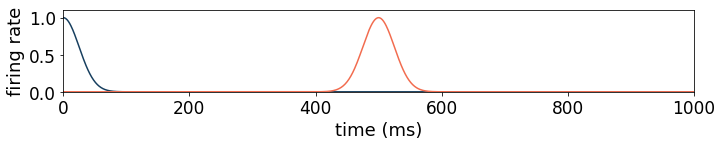

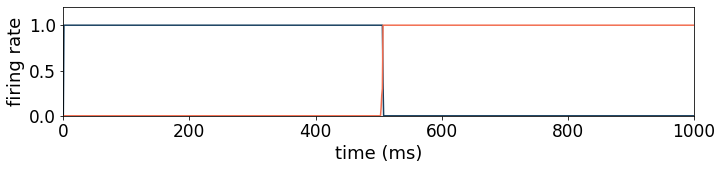

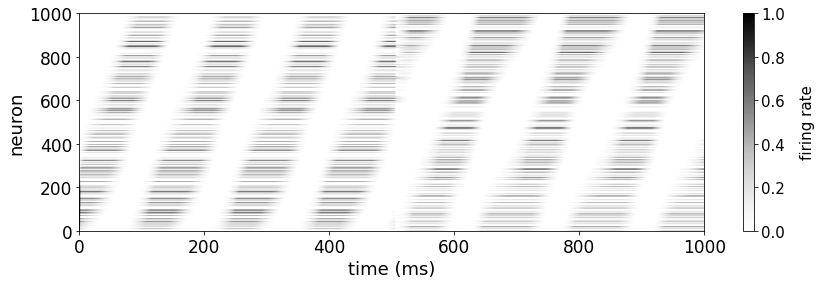

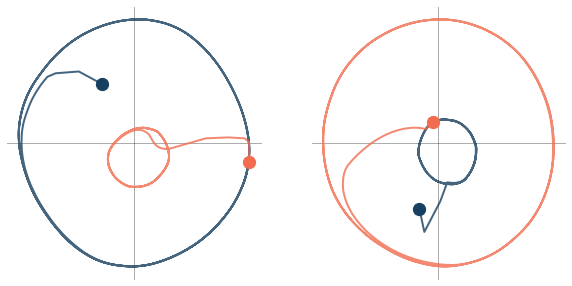

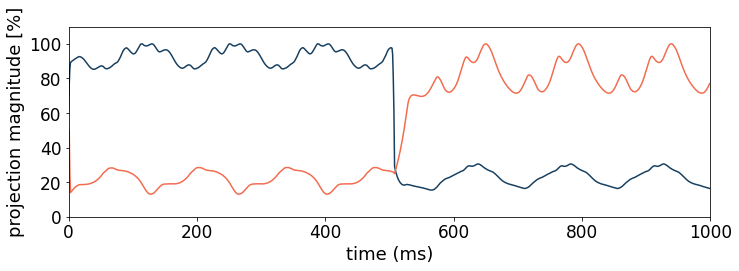

In [11]:
fname = 'top_down_signal.pdf'
plt.figure(figsize=(11.3,1.5))
plt.plot(t, I_ext_1/w_ext, color=colors[0])
plt.plot(t, I_ext_2/w_ext, color=colors[1])
plt.xlim(0,T)
plt.ylim(0,1.1)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('time (ms)', fontsize=18)
plt.ylabel('firing rate', fontsize=18)
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

fname = 'selective_inhibition.pdf'
plt.figure(figsize=(11.3,2))
plt.plot(net.I_1, color=colors[0])
plt.plot(net.I_2, color=colors[1]) 
plt.xlim(0,T)
plt.ylim(0,1.2)
plt.xticks(fontsize=17)
plt.yticks(np.arange(0,1.5,.5), fontsize=17)
plt.xlabel('time (ms)', fontsize=18)
plt.ylabel('firing rate', fontsize=18)
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

fname = 'raster.pdf'
fig, ax = plt.subplots(figsize=(14,4))
im = ax.imshow(net.R, aspect='auto', cmap='Greys', origin='lower', vmax=1)
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=15)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('firing rate', rotation=90, fontsize=15)
plt.xlim(0,T)
plt.ylim(0,1000)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('time (ms)', fontsize=18)
plt.ylabel('neuron', fontsize=18)
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

pc0 = 0
pc1 = 1

t_0 = 0#t_buffer
t_1 = t_ext_2 #np.where(I_ext_2/w_ext > 0.5)[0][0]#t_ext_2-2*sd
t_2 = T

fname = 'projections.pdf'
fig, ax = plt.subplots(1,2, figsize=(10,5))
proj_mag = np.zeros((2,T))

for i in range(2):
    # project
    proj = np.dot(pca_R[i].components_, R)
    c0_1 = proj[pc0,t_0:t_1], proj[pc1,t_0:t_1]
    c0_2 = proj[pc0,t_1:t_2], proj[pc1,t_1:t_2]

    j = 0
    ax[i].plot(*c0_1, colors[j%len(colors)], linewidth=2, zorder=10, alpha=0.8) #, alpha=(i+1)/nTrials)
    ax[i].scatter(c0_1[0][0], c0_1[1][0], c=colors[j%len(colors)], s=150, zorder=10, alpha=1)

    j = 1
    ax[i].plot(*c0_2, colors[j%len(colors)], linewidth=2, zorder=150, alpha=0.8) #, alpha=(i+1)/nTrials)
    ax[i].scatter(c0_2[0][0], c0_2[1][0], c=colors[j%len(colors)], s=150, zorder=100, alpha=1)

    #compute proj magnitude
    proj_mag[i,:] = np.sum(proj**2, axis=0)**0.5

    ax[i].set_xticks([], fontsize=17)
    ax[i].set_yticks([], fontsize=17)

    ax[i].spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    ax[i].spines['bottom'].set(alpha=0.4)
    ax[i].spines['left'].set(alpha=0.4)

    ax[i].spines['bottom'].set_position('center')
    ax[i].spines['left'].set_position('center')

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

fname = 'projection_magnitude.pdf'
plt.figure(figsize=(11.5,3.5))
plt.plot(proj_mag[0,:] / np.max(proj_mag[0,t_buffer:]), color=colors[0])
plt.plot(proj_mag[1,:] / np.max(proj_mag[1,t_buffer:]), color=colors[1])
plt.xlim(0,T)
plt.ylim(0,1.1)
plt.xticks(fontsize=17)
plt.yticks(np.arange(0,1.2,.2),np.arange(0,120,20),fontsize=17)
plt.xlabel('time (ms)', fontsize=18)
plt.ylabel('projection magnitude [%]', fontsize=18)
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

## Supplementary figure 5 - Correlation matrices

In [12]:
C_EE = np.zeros([N,N])
thr = 0.1*net.R.mean()
for i in range(N):
    for j in range(i,N):
        if (net.R[i,:].mean() > thr) & (net.R[j,:].mean() > thr):
            c = np.corrcoef(net.R[i,:], net.R[j,:])[0,1]
            C_EE[i,j] = c
            C_EE[j,i] = c

In [13]:
# figure storage
fig_dir = get_root() + 'figures/supplementary_figure_5/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('Directory already exists')
    
save_figs_flag = 1

Created /home/andrew/Documents/projects/submanifolds/submission_clustered_inhibition/rate_network/figures/supplementary_figure_5/


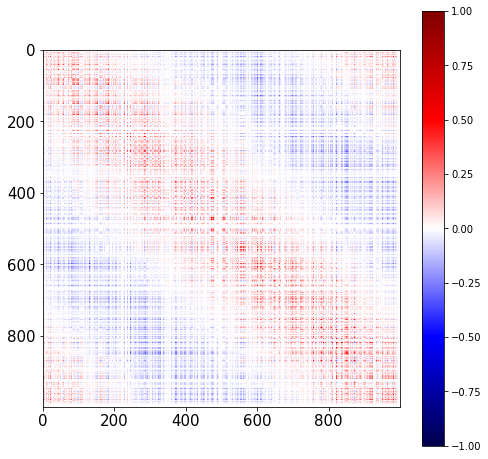

In [14]:
fname='C_EE_fig4data.pdf'
plt.figure(figsize=(8,8))
plt.imshow(C_EE,cmap='seismic',vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

alpha = 0.0
for i in range(int(p*N)):
    plt.plot(np.arange(0,N), inds_1[i]*np.ones(N),color='black', alpha=alpha)
    plt.plot(inds_1[i]*np.ones(N), np.arange(0,N), color='black', alpha=alpha)
    
    
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
    

plt.show()

In [15]:
C_EI = np.zeros([N,2])
for i in range(N):
    C_EI[i,0] = np.corrcoef(net.R[i,:], net.I_1)[0,1]
    C_EI[i,1] = np.corrcoef(net.R[i,:], net.I_2)[0,1]

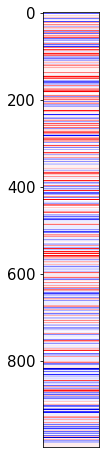

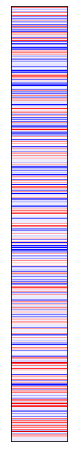

In [16]:
fname='C_EI_1_fig4data.pdf'
plt.figure(figsize=(1,8))
plt.imshow(C_EI[:,0:1], aspect='auto',cmap='seismic',vmin=-1,vmax=1)
#plt.colorbar()
plt.xticks([])
plt.yticks(fontsize=15)
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

fname='C_EI_2_fig4data.pdf'
plt.figure(figsize=(1,8))
plt.imshow(C_EI[:,1:2], aspect='auto',cmap='seismic',vmin=-1,vmax=1)
#plt.colorbar()
plt.xticks([])
plt.yticks([])
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

In [17]:
C_II = np.corrcoef(net.I_1, net.I_2)

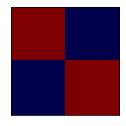

In [18]:
fname='C_II_fig4data.pdf'
plt.figure(figsize=(2,2))
plt.imshow(C_II, cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()
plt.xticks([])
plt.yticks([])
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()